# Window Function on 2D clustering

steps are :
1. Transform the theory cell to the theory omega                               
2.1 Transfrom the window cell to the window omega                               
2.2 Compute the window omega directly with paircounts                             
3. Multiply the theory omega by the window omega
4. Transform back the window-convolved theory omega to cell

In [1]:
## import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.special import eval_legendre as scipyLeg
from time import time
import logging
import sys
sys.path.insert(0, '/Users/rezaie/github/LSSutils')
from LSSutils import setup_logging

In [2]:
setup_logging('info')

In [3]:
plt.rc('font', size=20)#, family='serif')

In [11]:
def poly(x, *params):
    ans = params[0]
    for i in range(1, len(params)):
        ans += np.power(x, i)*params[i]
    return ans

def gauleg(ndeg, a=-1.0, b=1.0):
    '''
       Gauss-Legendre (default interval is [-1, 1])
    '''
    x, w = np.polynomial.legendre.leggauss(ndeg)
    # Translate x values from the interval [-1, 1] to [a, b]
    t = 0.5*(x + 1)*(b - a) + a
    w *= 0.5*(b - a)
    return t, w

def xi2cl(x, w, xi, nlmax):
    '''
        calculates Cell from omega
    '''
    cl  = []#np.zeros(nlmax+1)
    #m   = np.arange(nlmax+1)
    xiw = xi*w
    for i in range(nlmax+1):
        Pl    = np.polynomial.Legendre.basis(i)(x)
        #cl[i] = (xi * Pl * w).sum()
        cl.append((xiw * Pl).sum())
        
    cl = np.array(cl)
    cl *= 2.*np.pi
    return cl

def cl2xi(cell, costheta):
    '''
        calculates omega from Cell at Cos(theta)
    '''
    inv4pi = 0.07957747155 # 0.25/(np.pi)
    ell = np.arange(cell.size)
    coef = (2*ell+1) * cell
    coef *= inv4pi
    y = np.polynomial.legendre.legval(costheta, c=coef, tensor=False)
    return y


def apply_window_v0(clth, theta, xiw, theory=True):
    Xiw  = IUS(np.cos(theta), xiw)
    lmax = clth.size-1 
    x,w  = np.polynomial.legendre.leggauss(lmax)
    xith = cl2xi(clth, x)
    xiw  = Xiw(x)
    if theory:
        xif  = xith * xiw
    else:
        xif  = xith / xiw
    
    clf  = xi2cl(x, w, xif, lmax)
    return clf, (x, xif)  


class CellTheory:
    
    logger = logging.getLogger('CellTheory')
    
    def __init__(self, 
                 cellfile='/Volumes/TimeMachine/data/mocks/fftloggz0.85redbias2.out',
                 lmax=10000):
        
        self.l_mod, self.cl_mod = np.loadtxt(cellfile, usecols=(0,1), unpack=True)
        
        self.lmax = int(self.l_mod.max())
        self.lmin = int(self.l_mod.min())
        
        self.logger.info(f'ellmin = {self.lmin}, C_ellmin = {self.cl_mod[0]}')        
        self.logger.info(f'ellmax = {self.lmax}, C_ellmax = {self.cl_mod[-1]}')  
        
        if self.lmin != 0.0:
            self.logger.warning(f'insert 0.0 for ell=0')
            self.cl_mod = np.insert(self.cl_mod, 0, 0.0)
                
        if lmax > self.lmax:
            self.logger.info(f'extend to {lmax}')
            self._extend(lmax)
            self.lmax = lmax

    def convolve(self, XIW, lmax=512, ngauss=4*1024):
        assert lmax <= self.lmax, 'lmax is too high'
        t0 = time()
        #--- convolve the theory with the window
        cos_sep, weights = np.polynomial.legendre.leggauss(ngauss)
        mid_sep = np.arccos(cos_sep)

        xi_window = XIW(mid_sep)
        xi_model = self.toxi(cos_sep)

        t1 = time()
        print(f'cl2xi : {t1-t0:6.1f} s')

        xi_mod_wind = xi_model * xi_window
        scalefactor = xi_model.sum()/xi_mod_wind.sum()
        xi_mod_wind *= scalefactor
        cl_mod_wind = xi2cl(cos_sep, weights, xi_mod_wind, lmax)

        t2 = time()

        print(f'xi2cl : {t2-t1:6.1f} s')


        return {'ell':np.arange(lmax+1), 
               'Cell':self.cl_mod_ex[:lmax+1],
               'Cellconv':cl_mod_wind,
               'Xiwindow':xi_window,
               'Ximodel':xi_model}    
        
    def _extend(self, lmax):
        
        # fit
        self.params,_ = curve_fit(self._lncl, 
                                  np.log(self.l_mod[-10:]),
                                  np.log(self.cl_mod[-10:]), 
                                  p0=[1., 0.])
        
        clmod_ext = list(self.cl_mod)
        for ell in range(self.lmax, lmax+1):
            clmod_ext.append(np.exp(self._lncl(np.log(ell), *self.params)))
        
        self.cl_mod_ex = np.array(clmod_ext)
        
        
    def _lncl(self, lnl, *params):
        return params[0]+lnl*params[1]-(np.exp(lnl)/self.lmax-1.)
                                
        
    def toxi(self, cos_sep):
        return cl2xi(self.cl_mod_ex, cos_sep)
    
    def plot(self, ax=None, **kwargs):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            
        if hasattr(self, 'cl_mod_ex'):
            ax.plot(self.cl_mod_ex, 'y-')
            
        ax.plot(self.cl_mod, 'g--')        
        ax.set(xscale='log', xlabel=r'$\ell$', ylabel=r'C$_\ell$')
        
    def load(self, 
             ximodel='/Volumes/TimeMachine/data/DR7/theta_omega_theory.txt'):
        self.sep_rad, self.xi_mod = np.loadtxt(ximodel).T
        self.dsep_rad = np.diff(self.sep_rad)
        
        
class XiWindow:
    
    def __init__(self, 
                 xifile='/Volumes/TimeMachine/data/DR7/dr7_window.cut.256.npy',
                 dof=8):
        '''
        '''
        result   = np.load(xifile, allow_pickle=True)
        sep      = result[0]
        self.rr  = result[1][0]
        if sep[0] > sep[1]:
            print('reordering arrays i.e., increasing')
            sep  = sep[::-1]
            self.rr  = self.rr[::-1]
        
        self.mid_sep = 0.5*(sep[:-1]+sep[1:])
        self.dsep = np.diff(sep)
        
        # norm
        self.rr_normed = self.rr / (np.sin(self.mid_sep)*self.dsep)
        self.rr_normed /= self.rr_normed[0]
        
        # fit
        self._fit(dof)
        norm = self(0.0)
        
        # renormaliza
        self.params = [p/norm for p in self.params]
        self.rr_normed /= norm
        
    def __call__(self, mid_sep):
        return poly(mid_sep, *self.params)
    
    
    def _fit(self, dof=8, nmodes_ext=50):
        mid_sep_ext = list(self.mid_sep)
        rr_ext = list(self.rr_normed)

        for j in range(nmodes_ext):
            # right end
            mid_sep_ext.append(self.mid_sep[-1]+(j+1)*self.dsep[-1-j])
            rr_ext.append(self.rr_normed[-1-j])

            # left end
            #mid_sep_ext.insert(0, xi_wind.mid_sep[0]-(j+1)*xi_wind.dsep[0])
            #rr_ext.insert(0, xi_wind.rr_normed[j+1])

        p0 = [0 for i in range(dof)]
        self.params,_ = curve_fit(poly, mid_sep_ext, rr_ext, p0=p0)    

In [3]:
frac = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits', verbose=False)
mask = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits', verbose=False) > 0
print(frac[mask].sum())

frac = hp.read_map('/Volumes/TimeMachine/data/mocks/fracgood.hp256.fits', verbose=False)
mask = hp.read_map('/Volumes/TimeMachine/data/mocks/mask.cut.w.hp.256.fits', verbose=False) > 0
print(frac[mask].sum())

179162.1875
86669.4032100406


## Step 1: Transfor theory Cell to Omega

In [31]:
# read paircount
paircount = '/Volumes/TimeMachine/data/DR7/dr7_window.cut.256.npy'
XIW = XiWindow(paircount)


# ---  theoretical C_ell ---
fftlog = '/Volumes/TimeMachine/data/mocks/fftlog.out'
CFFT = CellTheory(fftlog)

fftlog2 = '/Volumes/TimeMachine/data/mocks/fftloggz0.85redbias2.out'
CFFT2 = CellTheory(fftlog2)


clwind = CFFT.convolve(XIW)
clwind2 = CFFT2.convolve(XIW)

[ 006651.78 ]   0: 04-05 01:36  CellTheory      INFO     ellmin = 1, C_ellmin = 1.412047814e-06
[ 006651.78 ]   0: 04-05 01:36  CellTheory      INFO     ellmax = 1000, C_ellmax = 4.908878061e-08
[ 006651.78 ]   0: 04-05 01:36  CellTheory      WARNING  insert 0.0 for ell=0
[ 006651.78 ]   0: 04-05 01:36  CellTheory      INFO     extend to 10000
[ 006651.85 ]   0: 04-05 01:36  CellTheory      INFO     ellmin = 1, C_ellmin = 2.952412205e-06
[ 006651.85 ]   0: 04-05 01:36  CellTheory      INFO     ellmax = 1000, C_ellmax = 4.919616419e-08
[ 006651.85 ]   0: 04-05 01:36  CellTheory      WARNING  insert 0.0 for ell=0
[ 006651.85 ]   0: 04-05 01:36  CellTheory      INFO     extend to 10000


reordering arrays i.e., increasing
cl2xi :    3.9 s
xi2cl :    4.3 s
cl2xi :    3.3 s
xi2cl :    4.3 s


/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


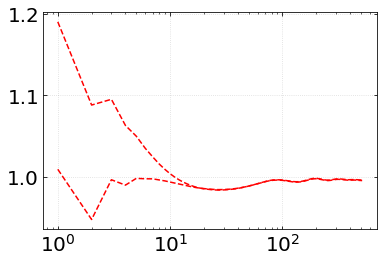

In [32]:
fig, ax = plt.subplots()

for cli in [clwind, clwind2]:    
    ax.plot(cli['Cellconv']/cli['Cell'], 'r--')
ax.set_xscale('log')
ax.tick_params(direction='in', which='both', axis='both', top=True, right=True)
ax.grid(True, ls=':', color='grey', alpha=0.3)


In [27]:
np.save('/Volumes/TimeMachine/data/DR7/results_referee/cl_window_model.npy',
       {'rsd':clwind2, 'norsd':clwind})

In [28]:
# read paircount
paircount = '/Volumes/TimeMachine/data/mocks/mocks_window.cut.256.npy'
XIW = XiWindow(paircount)


# ---  theoretical C_ell ---
fftlog = '/Volumes/TimeMachine/data/mocks/fftlog.out'
CFFT = CellTheory(fftlog)

fftlog2 = '/Volumes/TimeMachine/data/mocks/fftloggz0.85redbias2.out'
CFFT2 = CellTheory(fftlog2)


clwind = CFFT.convolve(XIW)
clwind2 = CFFT2.convolve(XIW)

[ 006490.73 ]   0: 04-05 01:33  CellTheory      INFO     ellmin = 1, C_ellmin = 1.412047814e-06
[ 006490.73 ]   0: 04-05 01:33  CellTheory      INFO     ellmax = 1000, C_ellmax = 4.908878061e-08
[ 006490.73 ]   0: 04-05 01:33  CellTheory      WARNING  insert 0.0 for ell=0
[ 006490.73 ]   0: 04-05 01:33  CellTheory      INFO     extend to 10000
[ 006490.80 ]   0: 04-05 01:33  CellTheory      INFO     ellmin = 1, C_ellmin = 2.952412205e-06
[ 006490.81 ]   0: 04-05 01:33  CellTheory      INFO     ellmax = 1000, C_ellmax = 4.919616419e-08
[ 006490.81 ]   0: 04-05 01:33  CellTheory      WARNING  insert 0.0 for ell=0
[ 006490.81 ]   0: 04-05 01:33  CellTheory      INFO     extend to 10000


reordering arrays i.e., increasing
cl2xi :    3.2 s
xi2cl :    4.3 s
cl2xi :    3.7 s
xi2cl :    4.3 s


/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


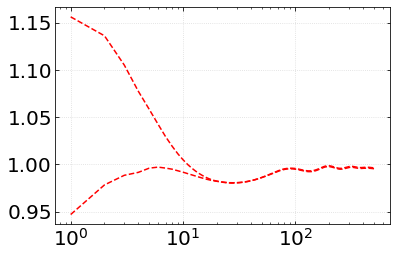

In [30]:
fig, ax = plt.subplots()

for cli in [clwind, clwind2]:    
    ax.plot(cli['Cellconv']/cli['Cell'], 'r--')
ax.set_xscale('log')
ax.tick_params(direction='in', which='both', axis='both', top=True, right=True)
ax.grid(True, ls=':', color='grey', alpha=0.3)

## Step 2: Multiply theory omega by window omega

In [8]:
# # fftlog2 = '/Volumes/TimeMachine/data/mocks/fftloggz0.85redbias2.out'
# # ebosscl = '/Volumes/TimeMachine/data/mocks/eBOSSELG.cell.dat'

# cl_fft = CellTheory(fftlog)
# cl_fft2 = CellTheory(fftlog2)
# cl_eboss = CellTheory(ebosscl)

# fig, ax = plt.subplots(figsize=(12, 6))

# for cl_modi in [cl_fft, cl_fft2, cl_eboss]:
#     ell = np.arange(cl_modi.cl_mod_ex.size)
    
#     ax.plot(ell, cl_modi.cl_mod_ex)
    
# ax.set(xlabel=r'$\ell$', ylabel=r'C$_\ell$', xscale='log')
# ax.grid(True, ls=':', alpha=0.5, which='both')


# def plot(cl_mod):
#     plt.plot(cl_mod.cl_mod_ex, 'y-',
#             cl_mod.cl_mod, 'g--')
#     return None


# plt.figure(figsize=(12, 8))

# # fig
# plot(cl_mod)
# plt.xscale('log')

# # sub fig
# plt.axes([0.55, 0.6, 0.3, 0.2])
# plot(cl_mod)
# plt.xlim(8.0e2, 1.2e3)
# plt.ylim(3.0e-8, 8.0e-8)

reordering arrays i.e., increasing


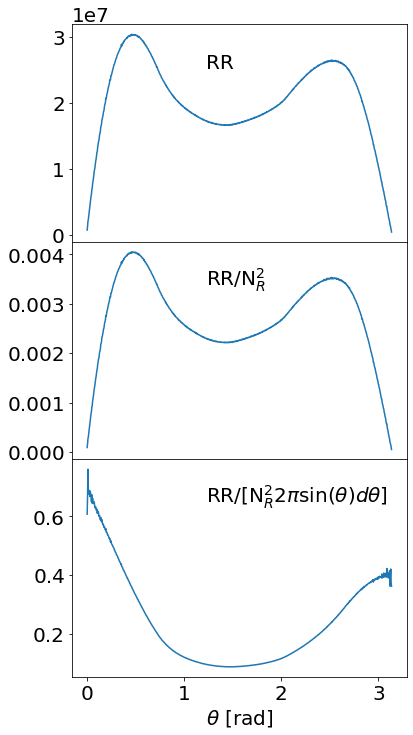

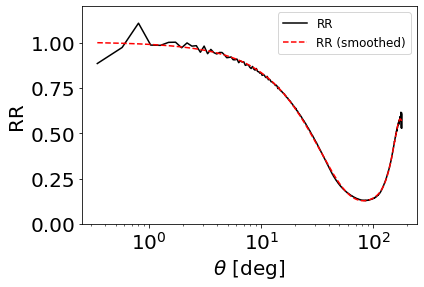

In [8]:
#--- data
# window xi x theory xi


# #xi_wind.smooth(saveto='/Volumes/TimeMachine/data/DR7/dr7_window_theta_omega.cut.256.txt')
# xi_wind.load(infile='/Volumes/TimeMachine/data/DR7/dr7_window_theta_omega.cut.256.txt', sf=0.6864554309873736)
# xi_wind.plot()

Text(0, 0.5, 'RR')

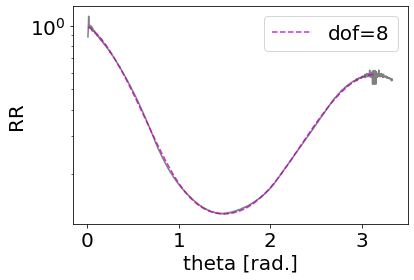

In [11]:
plt.plot(mid_sep_ext, rr_ext, color='grey')
# plt.plot(xi_wind.mid_sep, xi_wind.rr_normed, color='k')
plt.plot(xi_wind.mid_sep, poly(np.array(xi_wind.mid_sep), *params), 
         label='dof=%d'%dof, color='m', alpha=0.8, ls='--')


# plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('theta [rad.]')
plt.ylabel('RR')

cl2xi :   88.1 s
xi2cl :   17.5 s


In [14]:
scalefactor

1.0078988624823915

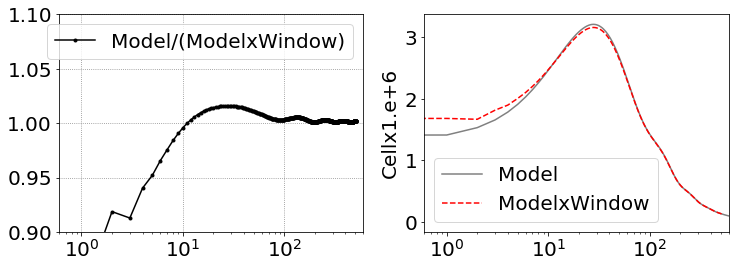

In [16]:
#
# plt.plot()
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))


ax[0].plot(np.arange(513), cl_fft.cl_mod_ex[:513]/cl_mod_wind, 
            marker='.', c='k')
ax[0].legend(['Model/(ModelxWindow)'])
# ax[0].legend()
ax[0].set_xscale('log')
ax[0].grid(True, ls=':', color='grey')
ax[0].set_ylim(0.9, 1.1)
ax[0].set_xlim(0.6, 600)

ax[1].plot(cl_fft.cl_mod_ex*1.0e+6, 'grey')
ax[1].plot(cl_mod_wind*1.0e+6, 'r--')
ax[1].set_ylabel('Cellx1.e+6')
ax[1].set_xlim(0.6, 600)
ax[1].legend(['Model', 'ModelxWindow'])
ax[1].set_xscale('log')



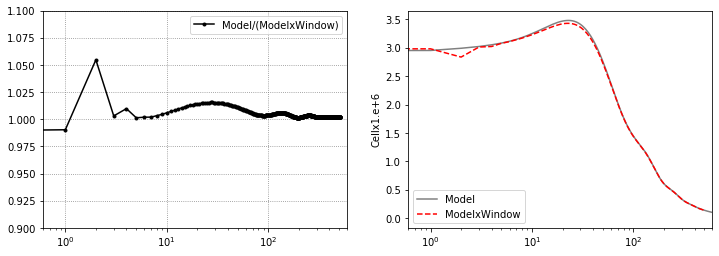

In [11]:
#
# plt.plot()
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))


ax[0].plot(np.arange(513), cl_mod.clmod[:513]/cl_mod_wind, 
            marker='.', c='k')
ax[0].legend(['Model/(ModelxWindow)'])
# ax[0].legend()
ax[0].set_xscale('log')
ax[0].grid(True, ls=':', color='grey')
ax[0].set_ylim(0.9, 1.1)
ax[0].set_xlim(0.6, 600)

ax[1].plot(cl_mod.cl_mod*1.0e+6, 'grey')
ax[1].plot(cl_mod_wind*1.0e+6, 'r--')
ax[1].set_ylabel('Cellx1.e+6')
ax[1].set_xlim(0.6, 600)
ax[1].legend(['Model', 'ModelxWindow'])
ax[1].set_xscale('log')


In [122]:
(cl_mod.clmod[512]/cl_mod_wind[512])

1.0021269460754634

In [ ]:
cl

In [91]:
cos_sep = np.cos(cl_mod.sep_rad)
xi_mod  = cl_mod.xi_mod

xi_mod_intp   = IUS(cos_sep[::-1], xi_mod[::-1])
xg, wg        = np.polynomial.legendre.leggauss(20)
xi_mod_wind   = xi_mod_intp(xg)*poly(np.arccos(xg), *params)
cl_mod_wind   = xi2cl(xg, wg, xi_mod_wind, 2000)

# plot
ell = np.arange(2000)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(cl_mod.cl_mod.size), cl_mod.cl_mod, 'k-',
         ell, cl_mod_wind[ell], 'r-')
plt.loglog()
plt.legend(['model', 'model conv. window'], fontsize=12)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.show()


# ell = np.arange(1001)
# plt.figure(figsize=(6, 4))
# plt.scatter(ell, cl_mod.cl_mod[ell]/cl_mod_wind[ell], color='k', marker='.')
# plt.xlabel(r'$\ell$')
# plt.title(r'$C_{Model}/C_{{\rm Model conv. Window}}$')
# plt.xlim(0.8, 1200)
# # plt.ylim(5.7, 6.3)
# plt.ylim(0.9, 1.1)
# plt.xscale('log')
# plt.show()



KeyboardInterrupt: 

reordering arrays i.e., increasing


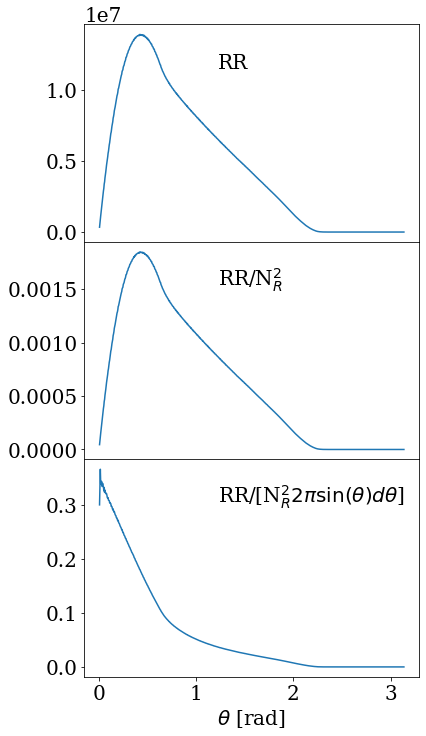

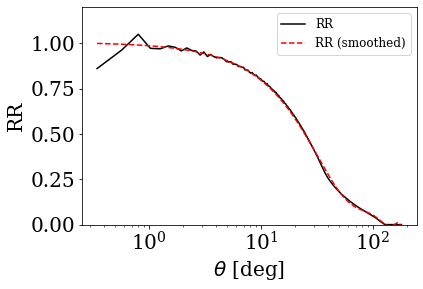

In [6]:
#--- mocks
# window xi x theory xi
xi_wind = XiWindow('/Volumes/TimeMachine/data/mocks/mocks_window.cut.256.npy',
                totalfrac=86669.4032)
#xi_wind.smooth()
# or 
xi_wind.load('/Volumes/TimeMachine/data/mocks/mocks_window_theta_omega.cut.256.txt',
            sf=0.3477201700151347)
xi_wind.plot()

In [73]:
def fix(x, y2):
    yc = y2.copy()
    m  = x>100
    xmin = x[m].min()
    yc[m] *= np.exp(-(x[m]-xmin)**2/900)
    return yc

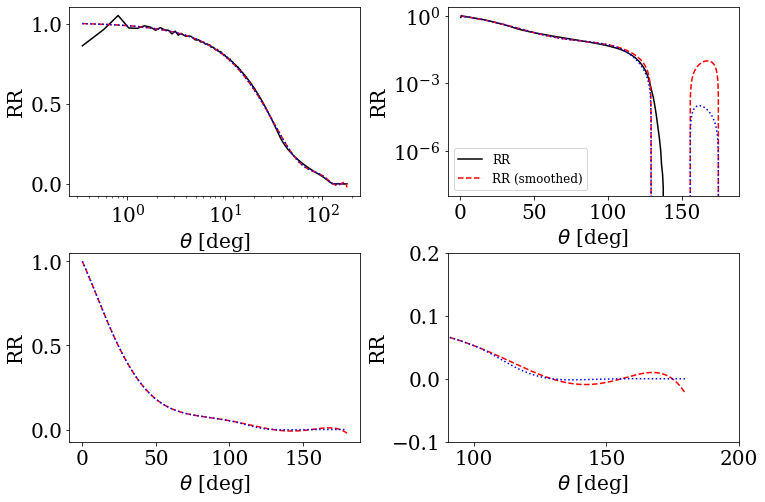

In [74]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
ax = ax.flatten()
fig.subplots_adjust(hspace=0.3, wspace=0.3)

y3 =fix(x, y2)
ax[0].plot(x, y1, 'k-', x, y2, 'r--', x, y3, 'b:')
ax[0].set(xscale='log',ylabel='RR', xlabel = r'$\theta$ [deg]')

ax[1].plot(x, y1, 'k-', x, y2, 'r--', x, y3, 'b:')
ax[1].legend(['RR', 'RR (smoothed)'], fontsize=12, loc=3)
ax[1].set(yscale='log',ylabel='RR', xlabel = r'$\theta$ [deg]')

ax[2].plot(x, y2, 'r--', x, y3, 'b:')
ax[2].set(ylabel='RR', xlabel = r'$\theta$ [deg]')

ax[3].plot(x, y2, 'r--',x, y3, 'b:')
ax[3].set(xlim=(90, 200), ylim=(-0.1, 0.2),ylabel='RR', xlabel = r'$\theta$ [deg]')
plt.show()

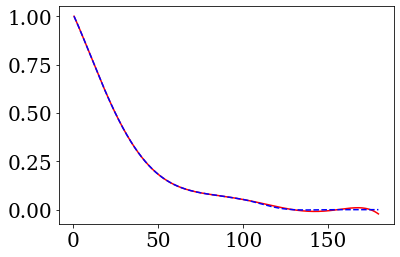

In [71]:
plt.plot(x, y2, 'r-',
        x, fix(x, y2), 'b--')

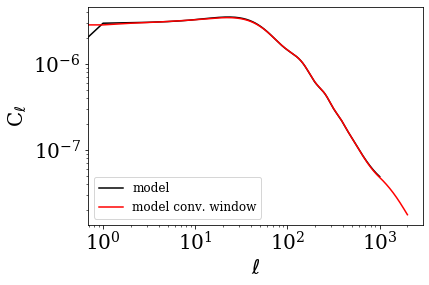

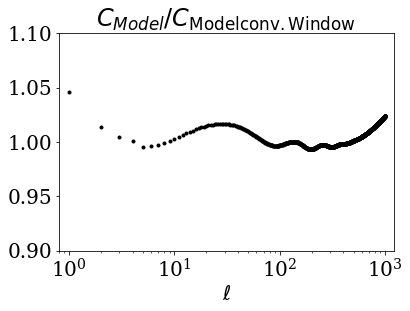

In [9]:
sep_rad  = np.linspace(0, np.pi, 20*181, endpoint=True)
dsep_rad = np.diff(sep_rad)
cos_sep  = np.cos(sep_rad)

xi_mod_intp = IUS(cos_sep[::-1], xi_mod[::-1])
xg, wg      = np.polynomial.legendre.leggauss(5000)
xi_mod_wind = xi_mod_intp(xg)*poly(np.arccos(xg), *params)/sf
cl_mod_wind = xi2cl(xg, wg, xi_mod_wind, xg.size)

# plot
ell = np.arange(2000)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(cl_mod.cl_mod.size), cl_mod.cl_mod, 'k-',
         ell, cl_mod_wind[ell], 'r-')
plt.loglog()
plt.legend(['model', 'model conv. window'], fontsize=12)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.show()


ell = np.arange(1001)
plt.figure(figsize=(6, 4))
plt.scatter(ell, cl_mod.cl_mod[ell]/cl_mod_wind[ell], color='k', marker='.')
plt.xlabel(r'$\ell$')
plt.title(r'$C_{Model}/C_{{\rm Model conv. Window}}$')
plt.xlim(0.8, 1200)
# plt.ylim(5.7, 6.3)
plt.ylim(0.9, 1.1)
plt.xscale('log')
plt.show()

np.savetxt('/Volumes/TimeMachine/data/mocks/mocks_ell_cell_theory_window.cut.256.txt', 
           np.column_stack([ell, cl_mod.cl_mod[ell], cl_mod_wind[ell]]),
           header='ell - Cell - Cell window conv.')

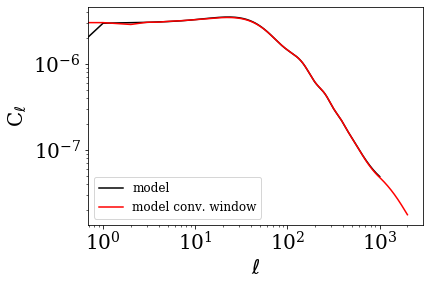

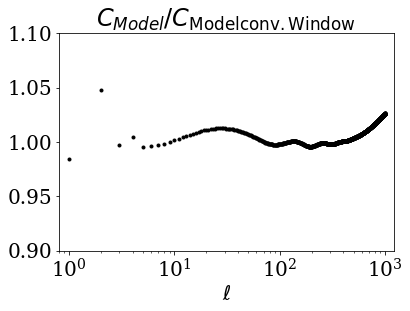

In [11]:
xi_mod_intp   = IUS(cos_sep[::-1], xi_mod[::-1])
xg, wg        = np.polynomial.legendre.leggauss(5000)
xi_mod_wind   = xi_mod_intp(xg)*poly(np.arccos(xg), *params)/sf
cl_mod_wind   = xi2cl(xg, wg, xi_mod_wind, xg.size)

# plot
ell = np.arange(2000)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(cl_mod.cl_mod.size), cl_mod.cl_mod, 'k-',
         ell, cl_mod_wind[ell], 'r-')
plt.loglog()
plt.legend(['model', 'model conv. window'], fontsize=12)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.show()


ell = np.arange(1001)
plt.figure(figsize=(6, 4))
plt.scatter(ell, cl_mod.cl_mod[ell]/cl_mod_wind[ell], color='k', marker='.')
plt.xlabel(r'$\ell$')
plt.title(r'$C_{Model}/C_{{\rm Model conv. Window}}$')
plt.xlim(0.8, 1200)
# plt.ylim(5.7, 6.3)
plt.ylim(0.9, 1.1)
plt.xscale('log')
plt.show()

np.savetxt('/Volumes/TimeMachine/data/DR7/dr7_ell_cell_theory_window.cut.256.txt', 
           np.column_stack([ell, cl_mod.cl_mod[ell], cl_mod_wind[ell]]),
           header='ell - Cell - Cell window conv.')

In [197]:
cl_obs = np.load('/Volumes/TimeMachine/data/DR7/results/clustering/cl_nn_ab.npy', 
                allow_pickle=True).item()

In [2]:
frac = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits', verbose=False)
mask = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits', verbose=False) > 0
frac[mask].sum()

NameError: name 'hp' is not defined

In [259]:
mask1024 = hp.ud_grade(mask, nside_out=1024)
frac1024 = hp.ud_grade(frac, nside_out=1024)

In [260]:
hpfrac = hp.ma(frac1024)

In [261]:
hpfrac.mask=np.logical_not(mask1024>0)

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


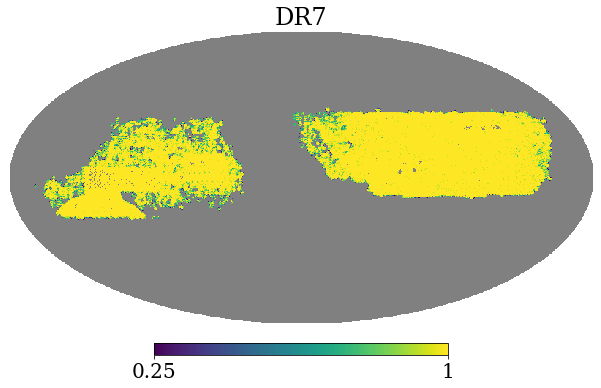

In [262]:
hp.mollview(hpfrac.filled(), rot=-89, title='DR7')

In [263]:
cl_win = hp.anafast(hpfrac.filled(), lmax=1024)

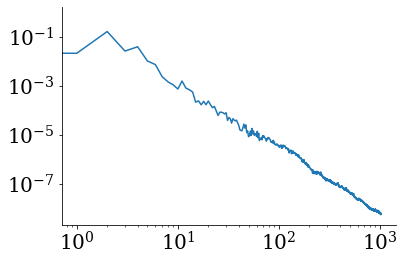

In [264]:
plt.loglog(cl_win)

In [265]:
xi_win = cl2xi(cl_win, cos_sep)

(0, 1)

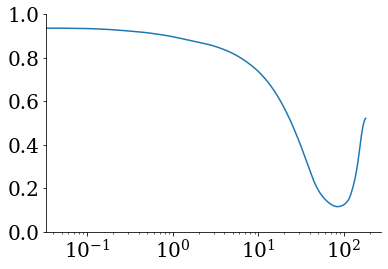

In [277]:
plt.plot(np.degrees(sep_rad), xi_win/0.23623275756835938)
plt.xscale('log')
plt.ylim(0, 1)

In [267]:
cl_obs_wind,_ = apply_window_v0(cl_obs['auto']*0.23429479830970087, sep_rad[::-1], xi_win[::-1]/0.23429479830970087, theory=False)

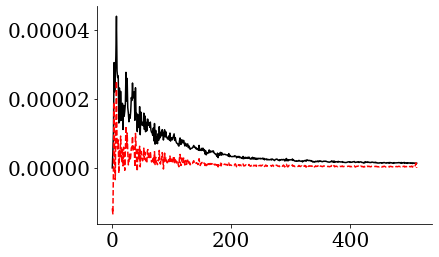

In [271]:
plt.plot(cl_obs['auto'], 'k-',
        cl_obs_wind, 'r--')
# plt.loglog()
# plt.ylim(1.e-9, 1.e-5)

In [273]:
mask.mean()

0.23623275756835938

In [ ]:
## uses Ashley's approach,
## does not allow multiple zero crossings

# import sys
# sys.path.append('/Users/rezaie/github/LSSanalysis')
# import legendre
# from time import time

# Leg = np.vectorize(legendre.legendre)
# x = np.linspace(-1.0, 1., 100, endpoint=True)
# c = np.zeros(5001)
# for j in [0, 1, 2]:
#     t1 = time()
#     y1 = scipyLeg(j, x)
#     t2 = time()
#     y2= Leg(j, x)
#     t3 = time()
#     plt.plot(x, y1, color='b', ls='-', alpha=0.5)
#     plt.plot(x, y2, color='r', ls=':')
#     print('scipy', t2-t1)
#     print('ashley', t3-t2)


# t     = np.linspace(0., 180., num=4*181, endpoint=True)
# cost  = np.cos(np.deg2rad(t))
# Omega = np.zeros(cost.size)

# elmax = 10000
# clmod = cl_mod.run(np.arange(elmax+10))

# fig, ax = plt.subplots(nrows=3, figsize=(10, 6), sharey=True,
#                       sharex=True)
# ls = ['-', '-.', '--']
# j = 0
# #for cr_limit in [500]:
# #    print(cr_limit)
# cr_limit=1.0e24
# for elmax_l in [10000]:#, 2000, 5000]:
#     for i,cost_i in enumerate(cost):
#         Omega[i] = 0.0
#         el     = 1
#         domega = 0.0
#         omega  = 0.0
#         cr     = 0
#         oldpl  = 1
#         while (cr <= cr_limit) & (el < elmax_l):
#             pl = scipyLeg(el, cost_i)
#             domega = (2*el+1)*pl*clmod[el]
#             #print(pl, oldpl)
#             #if (pl < 0) and (oldpl > 0):
#             #    cr += 1
#             el    += 1
#             omega += domega
#             oldpl  = pl
#         if i <3:print('i:{}, el:{}'.format(i, el))
#         Omega[i] = omega
#     Omega *= (0.25/np.pi)
#     ax[j].plot(t, Omega/1.0e-5, ls=ls[j], 
#                label='Lmax=%d'%elmax_l, color='k')
#              #label='# of zero crossing = %d'%cr_limit)
#     ax[j].text(0.7, 0.1, 'Lmax=%d'%elmax_l, color='k', transform=ax[j].transAxes)
#     ax[j].axhline(linestyle=':', color='grey')
#     j += 1
#     print('Sum Omega = {}'.format(sum(Omega*t)))
# # plt.ylim(-4.e-3, 6.e-3)
# ax[0].set(ylim=(-2.5, 1.2), title='Theoretical $\omega$')
# ax[2].set(xlabel=r'$\theta$ [deg]')
# ax[1].set(ylabel=r'$\omega$ [1e-5]')

In [308]:
cl_obs = np.load('/Volumes/TimeMachine/data/DR7/results/clustering/cl_nn_ab.npy', 
                allow_pickle=True).item()

In [309]:
cl_obs.keys()

dict_keys(['cross', 'auto', 'clerr', 'clabels', 'sf'])

In [310]:
cl_obs['sf']

0.23429479830970087

In [311]:
cl_wobs,_ = apply_window_v0(cl_obs['auto']*0.23429479830970087, xi_th.sep, xi_th.xiw, theory=False)

In [312]:
cl_wmod,_ = apply_window_v0(cl_mod.cl_mod, xi_th.sep, xi_th.xiw, theory=True)

[]

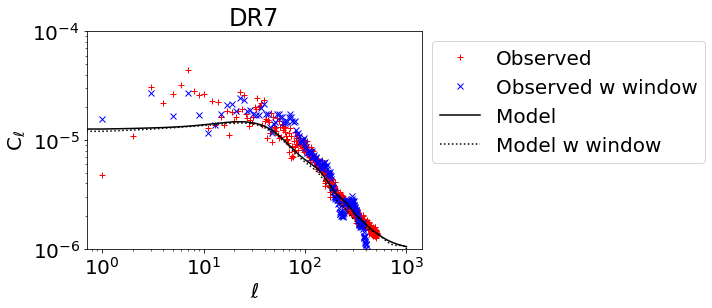

In [316]:
plt.plot(np.arange(cl_obs['auto'].size), cl_obs['auto'], marker='+', color='r', label='Observed', ls='None')
plt.plot(np.arange(cl_obs['auto'].size), cl_wobs*200,  marker='x', color='b', label='Observed w window', ls='None')

plt.plot(np.arange(cl_mod.cl_mod.size),  4*cl_mod.cl_mod  + 8.536537713893294e-07, 'k-',      label='Model')
plt.plot(np.arange(cl_wmod.size), 4*cl_wmod/720 + 8.536537713893294e-07, 'k:',      label='Model w window')
plt.ylim(1.e-6, 1.e-4)
plt.legend(bbox_to_anchor=(1., 1))
plt.title('DR7')
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.loglog()
#plt.xlim(0.9, 1000)
# plt.yscale('log')